<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Все-функции" data-toc-modified-id="Все-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Все функции</a></span><ul class="toc-item"><li><span><a href="#Функции-перевода-изображения-в-монохромный-формат-и-resize." data-toc-modified-id="Функции-перевода-изображения-в-монохромный-формат-и-resize.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции перевода изображения в монохромный формат и resize.</a></span></li><li><span><a href="#Функции-разрезания-на-ленты" data-toc-modified-id="Функции-разрезания-на-ленты-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции разрезания на ленты</a></span><ul class="toc-item"><li><span><a href="#Создание-матриц-&quot;внешнего-ленточного-умножения&quot;-на-примере-матриц-A-и-B" data-toc-modified-id="Создание-матриц-&quot;внешнего-ленточного-умножения&quot;-на-примере-матриц-A-и-B-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Создание матриц "внешнего ленточного умножения" на примере матриц A и B</a></span></li><li><span><a href="#Функция-внешнего-ленточного-умножения-двух-матриц" data-toc-modified-id="Функция-внешнего-ленточного-умножения-двух-матриц-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Функция внешнего ленточного умножения двух матриц</a></span></li><li><span><a href="#Ленточное-умножение-матрицы-на-транспонированную" data-toc-modified-id="Ленточное-умножение-матрицы-на-транспонированную-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Ленточное умножение матрицы на транспонированную</a></span></li></ul></li><li><span><a href="#Функция-рисования-списка-картинок" data-toc-modified-id="Функция-рисования-списка-картинок-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Функция рисования списка картинок</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time as tm

from skimage import io, color, img_as_float
from scipy.ndimage import map_coordinates
import cv2 


# Все функции

## Функции перевода изображения в монохромный формат и resize. 
А также функции умножения матрицы на транспонированную и различных нормализаций. 
Вдруг понадобятся ;-) 

In [2]:
t1_itogo = tm.time()

def monochrome(rgb_image):
    if len(rgb_image.shape) == 2:  # Проверяем, если изображение уже двумерное
        print("Изображение уже монохромное.")
        return rgb_image  # Возвращаем исходное изображение
    else:
        coeffs = np.array([0.299, 0.587, 0.114])
        return rgb_image @ coeffs


def resize_and_monochrome (picture, k):
    new_size = (round(picture.shape[1]/k), round(picture.shape[0]/k))
    picture = cv2.resize(picture, new_size, interpolation=cv2.INTER_AREA)
    picture_monochrome = monochrome(picture)
    return picture, picture_monochrome



In [3]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res

def norm_columns(x):
    columns_sums = np.sum(x, axis=0)
    columns_sums[columns_sums == 0] = np.finfo(float).eps
    # Убедимся, что нормализация применяется корректно
    return x / columns_sums[np.newaxis, :]

# поправила norm_rows, а то там появляется деление на ноль
def norm_rows(x):
    row_sums = np.sum(x, axis=1)
    # Замена нулей на очень маленькое число, чтобы избежать деления на ноль
    row_sums[row_sums == 0] = np.finfo(float).eps
    return x / row_sums[:, np.newaxis]


def trans_mult(A):
    result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))
    return result

def trans_mult_norm(A):
    result = normalize_image(np.dot(norm_rows(monochrome(A)), norm_columns(np.transpose(monochrome(A)))))
    return result

def trans_mult_norm_plus_1(A):
    B = A+1
    result = normalize_image(np.dot(norm_rows(monochrome(B)), norm_columns(np.transpose(monochrome(B)))))
    return result

def normalize_image_signed(img):
    img1 = img - np.min(img)
    img2 = (2 / np.max(img1)) * img1
    return img2 - 1


def trans_mult_signed(A):
    B = normalize_image_signed(monochrome(A))
    result = normalize_image(np.dot(B, np.transpose(B)))
    return result

## Функции разрезания на ленты

### Создание матриц "внешнего ленточного умножения" на примере матриц A и B

In [4]:
# А теперь возьмем m x n и n x k

num_rows_A = 7
num_columns_A = 9
strip_width = 2
number_strips_A = num_columns_A // strip_width if num_columns_A % strip_width == 0 else num_columns_A // strip_width + 1
 

A = np.random.randint(-10, 21, size=(num_rows_A, num_columns_A))

# Разделение матрицы A на number_strips матриц размером num_rows_A*strip_width и одну матрицу "остатка" num_rows*last_strip 
# last_strip = num_columns_A%strip_width

# вот вертикальные Ленты", получившиеся из матрицы А
sub_matrices_A = np.array_split(A, number_strips_A, axis=1)




num_rows_B = 9
num_columns_B = 5
strip_width = 2
number_strips_B = num_rows_B // strip_width if num_rows_B % strip_width == 0 else num_rows_B // strip_width + 1
# last_strip_B = num_rows_B%strip_width пока закомментим

B = np.random.randint(-3, 10, size=(num_rows_B, num_columns_B))


# вот горизонтальные ленты, получившиеся из матрицы В 
sub_matrices_B = np.array_split(B, number_strips_B, axis=0)


print('Это у нас вторая вертикальная  "лента". Когда режем А.')
print(sub_matrices_A[1])
print()
print('Это у нас вторая горизонтальная  "лента". Когда режем В')
print(sub_matrices_B[1])
print()


print('форма вертикальных лент, нарезанных из матрицы А', sub_matrices_A[1].shape)
print('форма горизонтальных лент, нарезанных из матрицы В',sub_matrices_B[1].shape)
print()

#создаем множество С
C = [0] * len(sub_matrices_A)


#а вот теперь само умножение вертикальных "лент" на горизонтальные
for i in range(len(sub_matrices_A)):
    print('матрица С номер ',i+1,':')
    C[i] = sub_matrices_A[i].dot(sub_matrices_B[i])
    print(C[i])
    print()


Это у нас вторая вертикальная  "лента". Когда режем А.
[[ 16   6]
 [ 10   8]
 [ -2 -10]
 [ -8  -1]
 [ -3   3]
 [ 13  11]
 [ 20  16]]

Это у нас вторая горизонтальная  "лента". Когда режем В
[[-1  7  8 -2 -3]
 [ 3  1  9  8 -1]]

форма вертикальных лент, нарезанных из матрицы А (7, 2)
форма горизонтальных лент, нарезанных из матрицы В (2, 5)

матрица С номер  1 :
[[ 12 -20 -32 -32 -16]
 [  0   7  19  25   5]
 [-61  97 150 146  78]
 [ 35 -49 -68 -60 -40]
 [-38  47  57  43  39]
 [-26  55 101 111  43]
 [-50  39  13 -25  35]]

матрица С номер  2 :
[[   2  118  182   16  -54]
 [  14   78  152   44  -38]
 [ -28  -24 -106  -76   16]
 [   5  -57  -73    8   25]
 [  12  -18    3   30    6]
 [  20  102  203   62  -50]
 [  28  156  304   88  -76]]

матрица С номер  3 :
[[ 84  76  96 164  88]
 [ 93  27 -33  78  51]
 [-20   4  31   1  -3]
 [-41  17  85  18   1]
 [-44  -4  37 -21 -17]
 [-20   4  31   1  -3]
 [ 64  96 166 194  98]]

матрица С номер  4 :
[[  2  99 165 -42 189]
 [ 28 119 138 -45 112]
 [-

### Функция внешнего ленточного умножения двух матриц

In [5]:
def block_outer_product_decomposition(A, B, strip_width):
    num_strips_A = A.shape[1] // strip_width if A.shape[1] % strip_width == 0 else A.shape[1] // strip_width + 1
    sub_matrices_A = np.array_split(A, number_strips_A, axis=1)
    
    
    # печать второй ленты потом уберем, это для проверки
    
    print('Это у нас вторая вертикальная  "лента". Когда режем А.')
    print(sub_matrices_A[1])
    print()
    
    number_strips_B = num_rows_B // strip_width if num_rows_B % strip_width == 0 else num_rows_B // strip_width + 1
    sub_matrices_B = np.array_split(B, number_strips_B, axis=0)
    
    print('Это у нас вторая горизонтальная  "лента". Когда режем В.')
    print(sub_matrices_B[1])
    print()
    
    print('форма вертикальных лент, нарезанных из матрицы А', sub_matrices_A[1].shape)
    print('форма горизонтальных лент, нарезанных из матрицы В',sub_matrices_B[1].shape)
    print()
    
    C = [0] * len(sub_matrices_A)


    #а вот теперь само умножение вертикальных "лент" на горизонтальные
    for i in range(len(sub_matrices_A)):
        print('матрица С номер ',i+1,':')
        C[i] = sub_matrices_A[i].dot(sub_matrices_B[i])
        print(C[i])
        print()
    return C
# а почему после return обязательно печатиается то, что  return? спросить у ChatGPT

In [6]:
# проверяем работу функции ленточного умножения матриц

num_rows_A = 7
num_columns_A = 9
A = np.random.randint(-10, 21, size=(num_rows_A, num_columns_A))

num_rows_B = 9
num_columns_B = 5
B = np.random.randint(-3, 10, size=(num_rows_B, num_columns_B))


block_outer_product_decomposition(A, B, 2)

Это у нас вторая вертикальная  "лента". Когда режем А.
[[ 12  14]
 [ 20 -10]
 [  1   6]
 [ -2   6]
 [  2  13]
 [-10 -10]
 [ -8  16]]

Это у нас вторая горизонтальная  "лента". Когда режем В.
[[2 5 4 7 5]
 [7 3 7 1 5]]

форма вертикальных лент, нарезанных из матрицы А (7, 2)
форма горизонтальных лент, нарезанных из матрицы В (2, 5)

матрица С номер  1 :
[[ 74  -9  -2 -44 104]
 [ -2   2  -1  -9   0]
 [-14 -11   8  82 -40]
 [-46   1   4  54 -72]
 [ 22 -12   5  41  16]
 [-20 -25  17 171 -72]
 [ 20 -10   4  32  16]]

матрица С номер  2 :
[[ 122  102  146   98  130]
 [ -30   70   10  130   50]
 [  44   23   46   13   35]
 [  38    8   34   -8   20]
 [  95   49   99   27   75]
 [ -90  -80 -110  -80 -100]
 [  96    8   80  -40   40]]

матрица С номер  3 :
[[ 57  38 235 -91 231]
 [ 27  18 147 -55 157]
 [ 18  12  12  -8 -10]
 [ 48  32 226 -86 232]
 [ -6  -4 106 -34 150]
 [-12  -8 -76  28 -84]
 [-24 -16 -80  32 -72]]

матрица С номер  4 :
[[-63 -12 -57 -24 -18]
 [300  80 200  60 120]
 [159  20 17

[array([[ 74,  -9,  -2, -44, 104],
        [ -2,   2,  -1,  -9,   0],
        [-14, -11,   8,  82, -40],
        [-46,   1,   4,  54, -72],
        [ 22, -12,   5,  41,  16],
        [-20, -25,  17, 171, -72],
        [ 20, -10,   4,  32,  16]]),
 array([[ 122,  102,  146,   98,  130],
        [ -30,   70,   10,  130,   50],
        [  44,   23,   46,   13,   35],
        [  38,    8,   34,   -8,   20],
        [  95,   49,   99,   27,   75],
        [ -90,  -80, -110,  -80, -100],
        [  96,    8,   80,  -40,   40]]),
 array([[ 57,  38, 235, -91, 231],
        [ 27,  18, 147, -55, 157],
        [ 18,  12,  12,  -8, -10],
        [ 48,  32, 226, -86, 232],
        [ -6,  -4, 106, -34, 150],
        [-12,  -8, -76,  28, -84],
        [-24, -16, -80,  32, -72]]),
 array([[-63, -12, -57, -24, -18],
        [300,  80, 200,  60, 120],
        [159,  20, 176,  85,  30],
        [264,  64, 196,  68,  96],
        [ 24,  24, -39, -37,  36],
        [270,  80, 155,  35, 120],
        [ 60, 

### Ленточное умножение матрицы на транспонированную

In [7]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res
# result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))

def monochrome(rgb_image):
    if len(rgb_image.shape) == 2:  # Проверяем, если изображение уже двумерное
        # print("Изображение уже монохромное.") # м.б. потом уберем
        return rgb_image  # Возвращаем исходное изображение
    else:
        coeffs = np.array([0.299, 0.587, 0.114])
        return rgb_image @ coeffs

def block_outer_product_trans_decomposition(A, strip_width):
    number_strips_A = A.shape[1] // strip_width if A.shape[1] % strip_width == 0 else A.shape[1] // strip_width + 1
    sub_matrices_A = np.array_split(monochrome(A), number_strips_A, axis=1)
    
    
    # потом все эти print закомментим, чтобы использовать их, когда что-то не так
    
    print('Это у нас вторая вертикальная  "лента". Когда режем А.')
    print(sub_matrices_A[1])
    print()
    
    B = np.transpose(monochrome(A))
    
    number_strips_B = A.shape[1] // strip_width if A.shape[1] % strip_width == 0 else A.shape[1] // strip_width + 1
    sub_matrices_B = np.array_split(B, number_strips_B, axis=0)
    
    print('Это у нас вторая горизонтальная  "лента". Когда режем В.')
    print(sub_matrices_B[1])
    print()
    
    print('форма вертикальных лент, нарезанных из матрицы А', sub_matrices_A[1].shape)
    print('форма горизонтальных лент, нарезанных из матрицы В',sub_matrices_B[1].shape)
    print()
    
    C = [0] * len(sub_matrices_A)
    C_total = 0


    #а вот теперь само умножение вертикальных "лент" на горизонтальные
    for i in range(len(sub_matrices_A)):
        #print('матрица С номер ',i+1,':')
        C[i]= normalize_image(np.dot((sub_matrices_A[i]), (sub_matrices_B[i])))
        #print(C[i])
        #print()
        C_total = C_total + C[i]
    return C, C_total

In [8]:
#проверка block_outer_product_trans_decomposition -
num_rows_A = 7
num_columns_A = 9
A = np.random.randint(-10, 21, size=(num_rows_A, num_columns_A))

block_outer_product, sum_outer_product = block_outer_product_trans_decomposition(A, 2)
block_outer_product[1]

Это у нас вторая вертикальная  "лента". Когда режем А.
[[15 -7]
 [19 16]
 [15 -2]
 [ 0 13]
 [ 8  1]
 [18  8]
 [ 5 12]]

Это у нас вторая горизонтальная  "лента". Когда режем В.
[[15 19 15  0  8 18  5]
 [-7 16 -2 13  1  8 12]]

форма вертикальных лент, нарезанных из матрицы А (7, 2)
форма горизонтальных лент, нарезанных из матрицы В (2, 7)



array([[0.51553672, 0.37288136, 0.46610169, 0.        , 0.28813559,
        0.43079096, 0.11581921],
       [0.37288136, 1.        , 0.48587571, 0.42231638, 0.36581921,
        0.79237288, 0.53389831],
       [0.46610169, 0.48587571, 0.4519774 , 0.09180791, 0.29519774,
        0.48728814, 0.20056497],
       [0.        , 0.42231638, 0.09180791, 0.36723164, 0.14689266,
        0.27542373, 0.34887006],
       [0.28813559, 0.36581921, 0.29519774, 0.14689266, 0.22033898,
        0.34322034, 0.2019774 ],
       [0.43079096, 0.79237288, 0.48728814, 0.27542373, 0.34322034,
        0.67655367, 0.39124294],
       [0.11581921, 0.53389831, 0.20056497, 0.34887006, 0.2019774 ,
        0.39124294, 0.36723164]])

In [9]:
%%time
# проверяем на parrot
parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 2)

strip_width = 100

C, sum_outer_product = block_outer_product_trans_decomposition(parrot, strip_width)
C[1]

Это у нас вторая вертикальная  "лента". Когда режем А.
[[217.16  217.801 219.801 ...  94.067  92.654  96.426]
 [214.16  217.16  219.16  ...  92.469  95.127  97.899]
 [212.16  215.046 217.046 ...  92.17   92.643  90.284]
 ...
 [ 48.031  42.145  44.917 ... 101.992 106.22  105.22 ]
 [ 43.917  41.031  48.39  ... 102.992 104.22  104.22 ]
 [ 47.276  48.504  47.276 ... 103.992  99.22  108.22 ]]

Это у нас вторая горизонтальная  "лента". Когда режем В.
[[217.16  214.16  212.16  ...  48.031  43.917  47.276]
 [217.801 217.16  215.046 ...  42.145  41.031  48.504]
 [219.801 219.16  217.046 ...  44.917  48.39   47.276]
 ...
 [ 94.067  92.469  92.17  ... 101.992 102.992 103.992]
 [ 92.654  95.127  92.643 ... 106.22  104.22   99.22 ]
 [ 96.426  97.899  90.284 ... 105.22  104.22  108.22 ]]

форма вертикальных лент, нарезанных из матрицы А (1415, 95)
форма горизонтальных лент, нарезанных из матрицы В (95, 1415)

CPU times: total: 891 ms
Wall time: 1.17 s


array([[0.50080556, 0.49544238, 0.48720858, ..., 0.22023423, 0.22193724,
        0.22556764],
       [0.49544238, 0.49066971, 0.48284625, ..., 0.21908087, 0.22077306,
        0.22431011],
       [0.48720858, 0.48284625, 0.47585358, ..., 0.21635008, 0.21805822,
        0.2215021 ],
       ...,
       [0.22023423, 0.21908087, 0.21635008, ..., 0.16021914, 0.16075101,
        0.16098644],
       [0.22193724, 0.22077306, 0.21805822, ..., 0.16075101, 0.16161609,
        0.16169805],
       [0.22556764, 0.22431011, 0.2215021 , ..., 0.16098644, 0.16169805,
        0.16216727]])

## Функция рисования списка картинок

In [10]:
def wrap_text(text, max_length):
   
    if len(text) <= max_length:
        return text
    # Находим пробел ближайший к середине строки для красивого переноса
    split_points = [i for i, char in enumerate(text) if char == ' ']
    best_split = min(split_points, key=lambda x: abs(x - max_length))
    return text[:best_split] + '\n' + wrap_text(text[best_split+1:], max_length)

# axes[1,0].set_title(wrap_text(f'{A_name} after \n{f_1_name}', 45))


def plot_images_in_rows(C, images_per_row=5):
    num_images = len(C)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 5*num_rows))
    
    for i in range(num_images):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axs[row_index, col_index].imshow(C[i], cmap = 'gray')
        axs[row_index, col_index].axis('off')
        axs[row_index, col_index].set_title(wrap_text(f'внешнее произведение лент номер {i+1}', 20))
    
    for i in range(num_images, num_rows * images_per_row):
        row_index = i // images_per_row
        col_index = i % images_per_row
        axs[row_index, col_index].axis('off')
    
    plt.show()


Это у нас вторая вертикальная  "лента". Когда режем А.
[[217.16  217.801 219.801 ...  94.067  92.654  96.426]
 [214.16  217.16  219.16  ...  92.469  95.127  97.899]
 [212.16  215.046 217.046 ...  92.17   92.643  90.284]
 ...
 [ 48.031  42.145  44.917 ... 101.992 106.22  105.22 ]
 [ 43.917  41.031  48.39  ... 102.992 104.22  104.22 ]
 [ 47.276  48.504  47.276 ... 103.992  99.22  108.22 ]]

Это у нас вторая горизонтальная  "лента". Когда режем В.
[[217.16  214.16  212.16  ...  48.031  43.917  47.276]
 [217.801 217.16  215.046 ...  42.145  41.031  48.504]
 [219.801 219.16  217.046 ...  44.917  48.39   47.276]
 ...
 [ 94.067  92.469  92.17  ... 101.992 102.992 103.992]
 [ 92.654  95.127  92.643 ... 106.22  104.22   99.22 ]
 [ 96.426  97.899  90.284 ... 105.22  104.22  108.22 ]]

форма вертикальных лент, нарезанных из матрицы А (1415, 95)
форма горизонтальных лент, нарезанных из матрицы В (95, 1415)



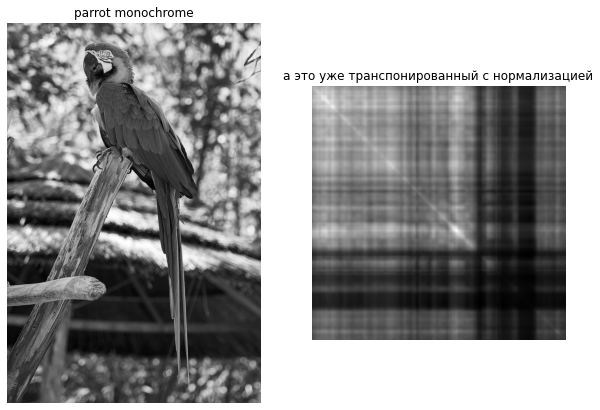

А теперь разложим произведение на транспонированное на ленты


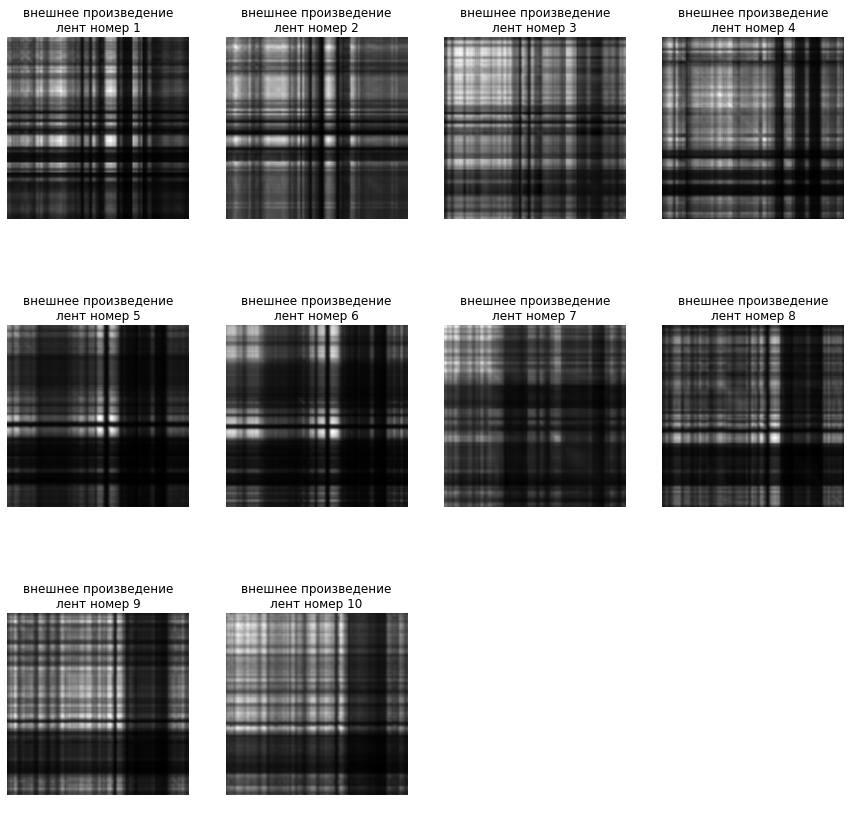

CPU times: total: 3.14 s
Wall time: 3.2 s


In [11]:
%%time
# проверяем рисование списка картинок
parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 2)

strip_width = 100
C, sum_outer_product= block_outer_product_trans_decomposition(parrot, strip_width)

fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(parrot, cmap='gray')
axes[0].set_title('parrot monochrome')
axes[0].axis('off')

    
axes[1].imshow(sum_outer_product, cmap='gray')
axes[1].set_title('а это уже транспонированный с нормализацией')
axes[1].axis('off')

plt.show()

print('А теперь разложим произведение на транспонированное на ленты')


plot_images_in_rows(C, images_per_row=4)



In [12]:
t2_itogo = tm.time()
print('вся тетрадка заняла', round(t2_itogo - t1_itogo)//60,'минут', round(t2_itogo - t1_itogo)%60,'секунд')

вся тетрадка заняла 0 минут 5 секунд
